In [1]:
import pricing
import model_calibration as model
import options as opt
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%load_ext autoreload
%autoreload 2

### Hedging strategy

In [3]:
S0 = 100
K = 100
T = 1
r = 0.04
vol = 0.2
M = 100000

In [163]:
### We start with a simple long call option 
### We buy a call option : we have to sell delta shares of the stock to hedge this option and adujst dynamicaly 
### this position throughout the life of the option

In [4]:
pnl = []
cash_position = []
stocks = []   ### the quantity of underlying stock buyed

### At time t=0

option_price_init = pricing.vanilla_option_price(S0, K, T, r, vol, M, antithetic=True)
delta_init = pricing.get_delta(pricing.vanilla_option_price, S0=S0, K=K, T=T, r=r, vol=vol, M=M, antithetic=True)
asset_price = S0

shares_to_buy = delta_init*asset_price
cash_position.append(-delta_init*asset_price)
stocks.append(shares_to_buy)

### At time t=t
### Suppose it's 10 days after t=0

T2 = T-(10/365)
S = 104   ### Let's assume that the price turned into 104 
delta = pricing.get_delta(pricing.vanilla_option_price, S0=S, K=K, T=T2, r=r, vol=vol, antithetic=True)
shares_to_buy = (delta-delta_init)*S
cash_position.append(shares_to_buy)
stocks.append(delta*S)

KeyboardInterrupt: 

In [201]:
asset_prices = pricing.monte_carlo_vectorized(S0=100, T=1, r=0.04, vol=0.2, M=50000, antithetic=True)
asset_prices

,1,2,3,4,5,6,7,8,9,10,...,49991,49992,49993,49994,49995,49996,49997,49998,49999,50000
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,98.649374,101.272502,100.365121,98.127929,99.281562,102.110514,96.996633,99.468972,101.615781,98.921801,...,98.528181,99.110866,99.335358,101.267494,101.605502,100.797002,98.777646,99.180671,100.374870,98.770790
2,100.311449,100.363230,99.428202,97.787820,97.979777,99.593885,95.764108,100.561295,100.925085,99.401300,...,99.612102,97.818076,98.233179,101.126216,101.741604,100.162472,100.267351,99.719399,101.751945,100.646146
3,102.808227,100.888442,102.108217,98.791281,96.376586,98.645300,95.445649,100.779735,102.263911,98.799103,...,98.956348,96.160842,100.059872,101.213025,100.979787,99.363717,100.140070,100.324465,102.549848,99.621779
4,101.384050,98.747575,101.967687,97.800352,97.601045,96.736206,95.004642,98.915478,99.795305,97.915406,...,97.552177,97.048807,101.868961,100.043695,100.688121,99.881966,98.977389,98.878223,99.649186,101.298219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,102.714178,78.562017,113.992821,90.481149,79.433848,93.740413,55.301525,81.598934,112.856492,116.553041,...,101.209048,96.806517,110.824301,73.075759,76.976214,116.323805,91.558417,99.337904,95.619936,112.819565
249,101.051998,78.341337,111.967821,92.867813,81.466003,93.541085,54.204329,80.924845,112.675470,117.052567,...,102.283561,96.691164,111.703136,73.387050,75.671477,117.333433,92.832925,98.911439,93.521098,113.207046
250,99.072665,78.094872,111.233414,94.202297,80.931403,91.658364,54.343281,80.695686,111.508207,117.289804,...,101.624989,96.770274,111.312049,74.241678,76.434673,115.187040,92.956653,96.986983,92.399433,112.645655
251,100.739549,79.239348,110.486873,93.890531,81.108200,91.253088,53.714347,81.346669,113.055674,117.388779,...,101.810392,94.920905,112.178349,73.620074,75.502827,114.980626,91.808125,96.891093,92.205918,112.899619


In [202]:
nbr_adjustments = 5   ### verifier que nbr_adjustments <= len(asset_prices)
adjustments = np.linspace(0, len(asset_prices)-1, nbr_adjustments).astype(int)
adjustments

array([  0,  63, 126, 189, 252])

In [ ]:
prices = asset_prices.loc[adjustments].mean(axis=1)
df = pd.DataFrame(columns=['Asset Prices'], data=prices)
df['Option Price'] = df.apply(lambda row: pricing.vanilla_option_price(S0=row['Asset Prices'], K=K, T=T-float(row.name)/252, r=r, vol=vol, M=M, antithetic=True), axis=1)
#df['BS Prices'] = df.apply(lambda row: opt.black_scholes(r=r, S=row['Asset Prices'], K=K, T=T-float(row.name)/252, sigma=vol), axis=1)
df['Delta'] = df.apply(lambda row: pricing.get_delta(pricing.vanilla_option_price, 
        S0=row['Asset Prices'], K=K, T=T-float(row.name)/252, r=r, vol=vol, M=M, antithetic=True), axis=1)
#df['BS Delta'] = df.apply(lambda row: opt.delta_calc(r=r, S=row['Asset Prices'], K=K, T=T-float(row.name)/252, sigma=vol), axis=1)
df['Shares Value'] = df['Asset Prices']*df['Delta']
df['Cash Position'] = np.where(df.index==0 ,- df['Delta']*df['Asset Prices'], (df['Delta'].shift(1)-df['Delta'])*df['Asset Prices']).cumsum()
df['PnL'] = df['Shares Value'] + df['Cash Position'] - df.iloc[0]['Option Price'] + df['Option Price']

c:\Users\Bouchereau Killian\OneDrive\Bureau\Finance\options_derivatives-1\options.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  d1=(np.log(S/K) + (r+sigma**2/2)*T)/(sigma*np.sqrt(T))
c:\Users\Bouchereau Killian\OneDrive\Bureau\Finance\options_derivatives-1\options.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  d1=(np.log(S/K) + (r+sigma**2/2)*T)/(sigma*np.sqrt(T))


In [5]:
def delta_hedge_option(function, num_hedging_adjustments, long=True, **kwargs):

    S0 = kwargs.get('S0', 100)
    T = kwargs.get('T', 1)
    r = kwargs.get('r', 0.04)
    vol = kwargs.get('vol', 0.2)
    M = kwargs.get('M', 50000)
    antithetic = kwargs.get('antithetic', False)

    new_kwargs = {key: value for key, value in kwargs.items() if key not in ['S0', 'T']}

    epsilon = 1 if long else -1

    asset_prices = pricing.monte_carlo_vectorized(S0=S0, T=T, r=r, vol=vol, M=M, antithetic=antithetic)
    if num_hedging_adjustments > len(asset_prices):
        raise ValueError("The number of dynamic hedging adjustments must be less than or equal to the number of timesteps in the asset price simulation")
    
    hedging_adjustments = np.linspace(0, len(asset_prices)-1, num_hedging_adjustments).astype(int)
    prices = asset_prices.loc[hedging_adjustments].mean(axis=1)
    df = pd.DataFrame(columns=['Asset Prices'], data=prices)
    df['Option Price'] = df.apply(lambda row: function(S0=row['Asset Prices'], T=T-float(row.name)/252, **new_kwargs), axis=1)
    df['Delta'] = df.apply(lambda row: pricing.get_delta(function, 
            S0=row['Asset Prices'], T=T-float(row.name)/252, **new_kwargs), axis=1)
    df['Shares Value'] = epsilon*df['Asset Prices']*df['Delta']
    df['Cash Position'] = np.where(df.index==0 , -epsilon*df['Delta']*df['Asset Prices']*np.exp(r*(T-df.index/252)), 
            epsilon*(df['Delta'].shift(1)-df['Delta'])*df['Asset Prices']*np.exp(r*(T-df.index/252))).cumsum()
    
    # Compute the payoff of the option hedged
    dictionary=pricing.dictionary()
    if function in dictionary:
        compute_payoff = dictionary[function]
    else:
        raise ValueError("There is no function yet to compute the payoff of this derivative")
    payoff_kwargs = {key: value for key, value in kwargs.items() if key not in ['S0']}
    df['Option Payoff'] = df.apply(lambda row: compute_payoff(S=row['Asset Prices'], long=long, **payoff_kwargs), axis=1)

    df['PnL'] = df['Shares Value'] + df['Cash Position'] - epsilon*df.iloc[0]['Option Price'] + epsilon*df['Option Payoff']
    return df

In [27]:
df = delta_hedge_option(pricing.vanilla_option_price, num_hedging_adjustments=250, long=True, S0=100, T=1, r=0.02, K=94, vol=0.2, M=50000, opt_type='C', antithetic=True)
df

,Asset Prices,Option Price,Delta,Shares Value,Cash Position,Option Payoff,PnL
0,100.000000,12.247904,0.695913,69.591330,-70.997168,6.000000,-7.653742
1,100.007875,12.227186,0.696434,69.648880,-71.050285,6.007875,-7.641434
2,100.015823,12.209397,0.697020,69.713057,-71.110102,6.015823,-7.629126
3,100.023647,12.196932,0.696887,69.705156,-71.096481,6.023647,-7.615582
4,100.031576,12.186044,0.696805,69.702519,-71.088157,6.031576,-7.601965
...,...,...,...,...,...,...,...
247,101.988506,8.026980,0.998206,101.805519,-101.839538,7.988506,-4.293417
248,101.998745,8.028689,0.999485,101.946229,-101.970068,7.998745,-4.272998
249,102.006347,8.028561,0.999962,102.002423,-102.018677,8.006347,-4.257810
250,102.014505,8.029372,0.999999,102.014452,-102.022549,8.014505,-4.241496


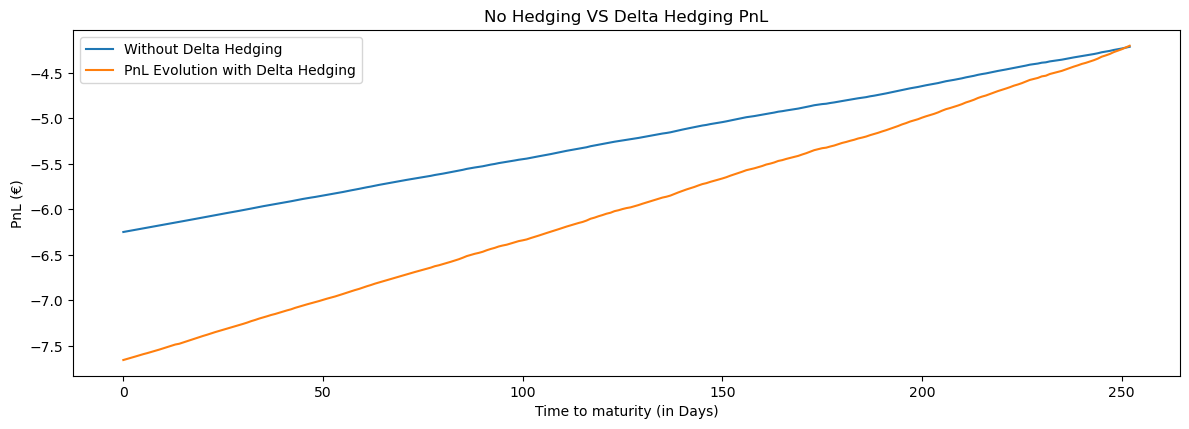

In [38]:
plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
plt.plot(df.index, df['Option Payoff']-df['Option Price'].iloc[0], label="Without Delta Hedging")
plt.plot(df.index, df['PnL'], label="PnL Evolution with Delta Hedging")
#plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Time to maturity (in Days)')
plt.ylabel("PnL (€)")
plt.title("No Hedging VS Delta Hedging PnL")
plt.legend(loc='upper left')

#plt.subplot(2, 1, 2)
#plt.plot(gamma_hedge.index, abs(gamma_hedge['Cash Position']), label="Cash Position (absolute value)", color="red")
#plt.plot(gamma_hedge.index, abs(gamma_hedge['Shares Value']), label="Shares Value (absolute value)", color="blue")
#plt.xlabel('Time to Maturity (in Days)')
#plt.ylabel("Portfolio (€)")
#plt.title("Evolution of Portfolio throughout Time to Maturity")
#plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [428]:
def gamma_hedge_option_old(function, num_hedging_adjustments, long=True, **kwargs):

    # Assumption : for the option to hedge, we use the same underlying asset -> same r, S, vol and T but K different

    S0 = kwargs.get('S0', 100)
    T = kwargs.get('T', 1)
    r = kwargs.get('r', 0.04)
    vol = kwargs.get('vol', 0.2)
    M = kwargs.get('M', 50000)
    antithetic = kwargs.get('antithetic', False)

    new_kwargs = {key: value for key, value in kwargs.items() if key not in ['S0', 'T']}

    epsilon = 1 if long else -1

    asset_prices = pricing.monte_carlo_vectorized(S0=S0, T=T, r=r, vol=vol, M=M, antithetic=antithetic)
    if num_hedging_adjustments > len(asset_prices):
        raise ValueError("The number of dynamic hedging adjustments must be less than or equal to the number of timesteps in the asset price simulation")
    
    hedging_adjustments = np.linspace(0, len(asset_prices)-1, num_hedging_adjustments).astype(int)
    prices = asset_prices.loc[hedging_adjustments].mean(axis=1)
    df = pd.DataFrame(columns=['Asset Prices'], data=prices)
    df['Option Price'] = df.apply(lambda row: function(S0=row['Asset Prices'], T=T-float(row.name)/252, **new_kwargs), axis=1)
    df['Gamma'] = df.apply(lambda row: pricing.get_gamma(function,
            S0=row['Asset Prices'], T=T-float(row.name)/252, **new_kwargs), axis=1)
    
    active_options = []

    def diff(params, S, maturity, target):
        K = params
        return (target-opt.gamma_calc(r=r, S=S, K=K, T=maturity, sigma=vol))**2

    optimal_params = []
    for index, row in df.iterrows():
        S = row['Asset Prices']
        target_gamma = row['Gamma']
        maturity = T-float(row.name)/252
        initial_guess = [S0]
        result = minimize(diff, initial_guess, args=(S, maturity, target_gamma), method='L-BFGS-B', bounds=[(0.1, 2*S0)])
        optimal_params.append(result.x)

    df['Optimal Strike'] = [params[0] for params in optimal_params]

    df['Hedge Option Gamma'] = df.apply(lambda row: 
         -epsilon*opt.gamma_calc(r=r, S=row['Asset Prices'], K=row['Optimal Strike'], T=T-float(row.name)/252, sigma=vol), axis=1)

    df['Options To Hedge'] = - df['Gamma'] / df['Hedge Option Gamma']
    df['Price Options To Hedge'] = df.apply(lambda row: 
            abs(row['Options To Hedge'])*opt.black_scholes(r=r, S=row['Asset Prices'], K=row['Optimal Strike'], T=T-float(row.name)/252, sigma=vol), axis=1)

    df['Delta'] = df.apply(lambda row: pricing.get_delta(function, 
            S0=row['Asset Prices'], T=T-float(row.name)/252, **new_kwargs)
            + opt.delta_calc(r=r, S=row['Asset Prices'], K=row['Optimal Strike'], T=T-float(row.name)/252, sigma=vol), axis=1)

    df.fillna(0, inplace=True)

    df['Shares Value'] = epsilon*df['Asset Prices']*df['Delta']
    df['Cash Position'] = np.where(df.index==0 , -epsilon*df['Delta']*df['Asset Prices']*np.exp(r*(T-df.index/252)), 
            epsilon*(df['Delta'].shift(1)-df['Delta'])*df['Asset Prices']*np.exp(r*(T-df.index/252))).cumsum()
    
    df['Options Buyed To Hedge'] = (df['Options To Hedge']*df['Price Options To Hedge']).cumsum()

    # Compute the payoffs of the options hedged
    def calculate_payoff(row, active_options):
        S = row['Asset Prices']
        payoffs = [option['Quantity'] * max(0, S - option['Strike']) for option in active_options]   ## Assumption : we buy only call for gamma hedge
        return sum(payoffs)

    hedge_payoffs = []
    for index, row in df.iterrows():
        if row['Options To Hedge'] != 0:
            active_options.append({
                'Strike': row['Optimal Strike'],
                'Quantity': abs(row['Options To Hedge'])
            })
    
        total_payoff = calculate_payoff(row, active_options)
        hedge_payoffs.append(total_payoff)

    df['Hedge Option Payoff'] = hedge_payoffs
    
    df['PnL'] = df['Shares Value'] + df['Cash Position'] - epsilon*df.iloc[0]['Option Price'] + epsilon*df['Option Price'] + df['Options Buyed To Hedge'] + df['Hedge Option Payoff']
    
    return df[['Asset Prices', 'Option Price', 'Gamma', 'Hedge Option Gamma', 'Options To Hedge', 
               'Price Options To Hedge', 'Options Buyed To Hedge', 'Hedge Option Payoff', 'Delta', 'Shares Value', 'Cash Position', 'PnL']]

In [31]:
def gamma_hedge_option(function, num_hedging_adjustments, long=True, **kwargs):

    # Assumption : for the option to hedge, we use the same underlying asset -> same r, S, vol and T but K different

    S0 = kwargs.get('S0', 100)
    T = kwargs.get('T', 1)
    r = kwargs.get('r', 0.02)
    vol = kwargs.get('vol', 0.2)
    M = kwargs.get('M', 50000)
    antithetic = kwargs.get('antithetic', False)

    new_kwargs = {key: value for key, value in kwargs.items() if key not in ['S0', 'T']}

    epsilon = 1 if long else -1

    asset_prices = pricing.monte_carlo_vectorized(S0=S0, T=T, r=r, vol=vol, M=M, antithetic=antithetic)
    if num_hedging_adjustments > len(asset_prices):
        raise ValueError("The number of dynamic hedging adjustments must be less than or equal to the number of timesteps in the asset price simulation")
    
    hedging_adjustments = np.linspace(0, len(asset_prices)-1, num_hedging_adjustments).astype(int)
    prices = asset_prices.loc[hedging_adjustments].mean(axis=1)
    df = pd.DataFrame(columns=['Asset Prices'], data=prices)
    df['Option Price'] = df.apply(lambda row: function(S0=row['Asset Prices'], T=T-float(row.name)/252, **new_kwargs), axis=1)
    df['Gamma'] = df.apply(lambda row: pricing.get_gamma(function,
            S0=row['Asset Prices'], T=T-float(row.name)/252, **new_kwargs), axis=1)
    
    df['Optimal Strike'] = 0.0
    df['Hedge Option Gamma'] = 0.0
    df['Options To Hedge'] = 0.0
    df['Price Options To Hedge'] = 0.0
    df['Total Gamma'] = 0.0
    df['Delta'] = 0.0
    df['Option Payoff'] = 0.0

    active_options = []

    def diff(params, S, maturity, target):
        K = params
        return (target-opt.gamma_calc(r=r, S=S, K=K, T=maturity, sigma=vol))**2
    
    hedge_payoffs = []

    # Compute the payoffs of the options hedged
    def calculate_payoff(S, active_options):
        payoffs = [option['Quantity'] * max(0, S - option['Strike']) for option in active_options]   ## Assumption : we buy only call for gamma hedge
        return sum(payoffs)
    
    # Compute the total delta
    def calculate_total_delta(S, active_options):
        total_delta = sum(
            option['Quantity'] * opt.delta_calc(r=r, S=S, K=option['Strike'], T=maturity, sigma=vol)
            for option in active_options
        )
        return total_delta

    j=0
    for i in df.index:
        S = df.loc[i, 'Asset Prices']
        maturity = T - float(i) / 252

        gamma_target = df['Gamma'][i] + df['Total Gamma'][j] if i > 0 else df['Gamma'][i]

        if gamma_target>0.05:
            initial_guess = [S0]
            result = minimize(diff, initial_guess, args=(S, maturity, gamma_target), method='L-BFGS-B', bounds=[(0.1, 2 * S0)])
            optimal_strike = result.x[0]
        
            df.loc[i, 'Optimal Strike'] = optimal_strike
            hedge_gamma = -epsilon * opt.gamma_calc(r=r, S=S, K=optimal_strike, T=maturity, sigma=vol)
            df.loc[i, 'Hedge Option Gamma'] = hedge_gamma

            if hedge_gamma != 0:
                options_to_hedge = -gamma_target / hedge_gamma
                df.loc[i, 'Options To Hedge'] = options_to_hedge
                option_price = abs(options_to_hedge) * opt.black_scholes(r=r, S=S, K=optimal_strike, T=maturity, sigma=vol)
                df.loc[i, 'Price Options To Hedge'] = option_price

                df.loc[i, 'Total Gamma'] = df['Total Gamma'][j] + options_to_hedge * hedge_gamma if i > 0 else options_to_hedge * hedge_gamma
            
                active_options.append({
                    'Strike': optimal_strike,
                    'Quantity': abs(options_to_hedge),
                })
            else:
                df.loc[i, 'Total Gamma'] = df['Total Gamma'][j] if i > 0 else 0

        else:
            df.loc[i, 'Optimal Strike'] = np.nan
            df.loc[i, 'Hedge Option Gamma'] = np.nan
            df.loc[i, 'Options To Hedge'] = np.nan
            df.loc[i, 'Price Options To Hedge'] = np.nan
            df.loc[i, 'Total Gamma'] = df['Total Gamma'][j]
        
        hedge_payoffs.append(calculate_payoff(df.loc[i, 'Asset Prices'], active_options))

        total_delta_options = calculate_total_delta(S, active_options)
        df.loc[i, 'Delta'] = (
            pricing.get_delta(function, S0=S, T=maturity, **new_kwargs) + total_delta_options
        )

        ## Test pour option vanille call
        #K = kwargs.get('K', S0)
        #df.loc[i, 'Option Payoff'] = max(0, df['Asset Prices'][i]-K)

        # Compute the payoff of the option hedged
        dictionary=pricing.dictionary()
        if function in dictionary:
            compute_payoff = dictionary[function]
        else:
            raise ValueError("There is no function yet to compute the payoff of this derivative")
        payoff_kwargs = {key: value for key, value in kwargs.items() if key not in ['S0']}
        df.loc[i, 'Option Payoff'] = compute_payoff(S=df['Asset Prices'][i], long=long, **payoff_kwargs)

        j=i

    df['Shares Value'] = epsilon*df['Asset Prices']*df['Delta']
    df['Cash Position'] = np.where(df.index==0 , -epsilon*df['Delta']*df['Asset Prices']*np.exp(r*(T-df.index/252)), 
            epsilon*(df['Delta'].shift(1)-df['Delta'])*df['Asset Prices']*np.exp(r*(T-df.index/252))).cumsum()
    
    df['Options Buyed To Hedge'] = (df['Options To Hedge'].fillna(0)*df['Price Options To Hedge'].fillna(0))
    df['Options Buyed To Hedge'] = df['Options Buyed To Hedge'].cumsum()

    df['Hedge Option Payoff'] = hedge_payoffs
    
    df['PnL'] = df['Shares Value'] + df['Cash Position'] - epsilon*df.iloc[0]['Option Price'] + epsilon*df['Option Payoff'] + df['Options Buyed To Hedge'] + df['Hedge Option Payoff']
    
    df.fillna(0, inplace=True)
    
    return df[['Asset Prices', 'Option Payoff', 'Option Price', 'Gamma', 'Total Gamma', 'Hedge Option Gamma', 'Options To Hedge', 
               'Price Options To Hedge', 'Options Buyed To Hedge', 'Hedge Option Payoff', 'Delta', 'Shares Value', 'Cash Position', 'PnL']]

In [32]:
gamma_hedge = gamma_hedge_option(pricing.vanilla_option_price, num_hedging_adjustments=10, long=True, S0=100, T=1, K=100, r=0.02, vol=0.2, M=10000, opt_type='C', antithetic=True)
gamma_hedge

c:\Users\Bouchereau Killian\OneDrive\Bureau\Finance\options_derivatives-1\options.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  d1=(np.log(S/K) + (r+sigma**2/2)*T)/(sigma*np.sqrt(T))


,Asset Prices,Option Payoff,Option Price,Gamma,Total Gamma,Hedge Option Gamma,Options To Hedge,Price Options To Hedge,Options Buyed To Hedge,Hedge Option Payoff,Delta,Shares Value,Cash Position,PnL
0,100.000000,0.000000,8.820140,0.006759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.578301,57.830073,-58.998318,-9.988385
28,100.214198,0.214198,8.350847,0.021063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.578077,57.931531,-58.975504,-9.649915
56,100.436281,0.436281,7.910135,0.011647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.576352,57.886645,-58.799520,-9.296734
84,100.664960,0.664960,7.466308,0.047880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.578796,58.264464,-59.048841,-8.939557
112,100.888529,0.888529,6.929194,0.026094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.581838,58.700747,-59.359152,-8.590016
140,101.088238,1.088238,6.380254,0.028189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.585124,59.149106,-59.694279,-8.277075
168,101.311395,1.311395,5.670762,0.052847,-0.052847,-0.033225,1.590566,9.024525,14.354105,2.085819,1.528559,154.860442,-155.914374,7.877246
196,101.526124,1.526124,4.796939,0.034593,-0.052847,0.000000,0.000000,0.000000,14.354105,2.427361,1.556891,158.065112,-158.803630,8.748933
224,101.748384,1.748384,3.728981,0.041718,-0.052847,0.000000,0.000000,0.000000,14.354105,2.780880,1.628669,165.714414,-166.123146,9.654497
252,101.983034,1.983034,1.983034,0.000000,-0.052847,0.000000,0.000000,0.000000,14.354105,3.154105,2.590566,264.193804,-264.220369,10.644539


In [42]:
gamma_hedge = gamma_hedge_option(pricing.vanilla_option_price, num_hedging_adjustments=50, long=True, S0=100, T=1, K=100, r=0.02, vol=0.2, M=10000, opt_type='C', antithetic=True)
delta_hedge = delta_hedge_option(pricing.vanilla_option_price, num_hedging_adjustments=50, long=True, S0=100, T=1, K=100, r=0.02, vol=0.2, M=10000, opt_type='C', antithetic=True)

c:\Users\Bouchereau Killian\OneDrive\Bureau\Finance\options_derivatives-1\options.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  d1=(np.log(S/K) + (r+sigma**2/2)*T)/(sigma*np.sqrt(T))


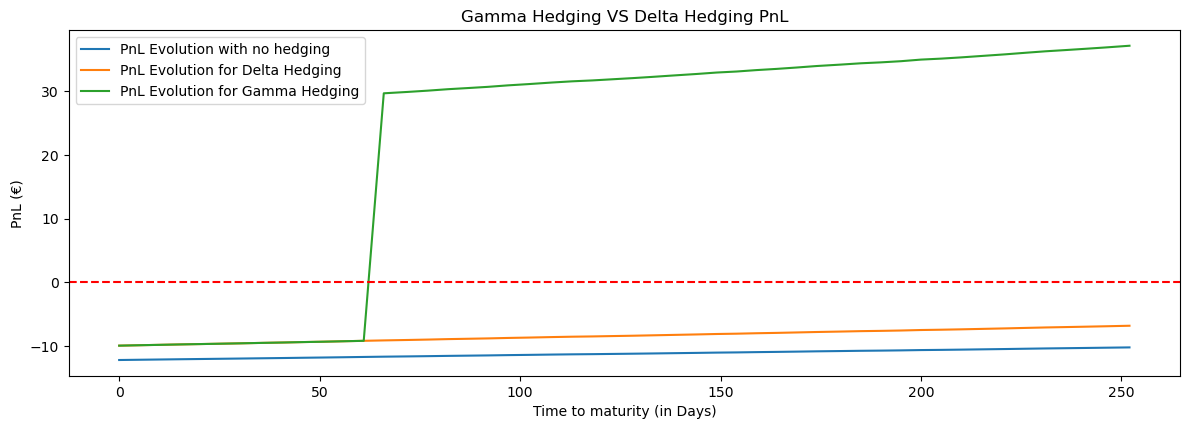

In [46]:
plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
plt.plot(delta_hedge.index, delta_hedge['Option Payoff']-df.iloc[0]['Option Price'], label="PnL Evolution with no hedging")
plt.plot(delta_hedge.index, delta_hedge['PnL'], label="PnL Evolution for Delta Hedging")
plt.plot(gamma_hedge.index, gamma_hedge['PnL'], label="PnL Evolution for Gamma Hedging")
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Time to maturity (in Days)')
plt.ylabel("PnL (€)")
plt.title("Gamma Hedging VS Delta Hedging PnL")
plt.legend(loc='upper left')

#plt.subplot(2, 1, 2)
#plt.plot(gamma_hedge.index, abs(gamma_hedge['Cash Position']), label="Cash Position (absolute value)", color="red")
#plt.plot(gamma_hedge.index, abs(gamma_hedge['Shares Value']), label="Shares Value (absolute value)", color="blue")
#plt.xlabel('Time to Maturity (in Days)')
#plt.ylabel("Portfolio (€)")
#plt.title("Evolution of Portfolio throughout Time to Maturity")
#plt.legend(loc='upper left')

plt.tight_layout()
plt.show()